# Script to perform the background removal on qsd2_w2 images

In [15]:
# Import necessary libraries
import imageio
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.ndimage import binary_opening, binary_closing, gaussian_filter, median_filter
from scipy import ndimage
import cv2


In [16]:
# Path to the images
image_folder = "../Data/Week2/qsd2_w2/"  # Update this path as necessary
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
mask_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
image_files.sort()
mask_files.sort()

In [17]:
def rgb2lab(image):
    """Convert an RGB image to LAB color space using the formula."""
    # Normalize RGB values to [0, 1]
    image = image / 255.0
    # Convert RGB to XYZ
    mask = image > 0.04045
    image[mask] = ((image[mask] + 0.055) / 1.055) ** 2.4
    image[~mask] = image[~mask] / 12.92
    image = image * 100

    # Observer = 2°, Illuminant = D65
    x = image[:, :, 0] * 0.4124564 + image[:, :, 1] * 0.3575761 + image[:, :, 2] * 0.1804375
    y = image[:, :, 0] * 0.2126729 + image[:, :, 1] * 0.7151522 + image[:, :, 2] * 0.0721750
    z = image[:, :, 0] * 0.0193339 + image[:, :, 1] * 0.1191920 + image[:, :, 2] * 0.9503041

    # Convert XYZ to LAB
    x /= 95.047
    y /= 100.000
    z /= 108.883

    mask = x > 0.008856
    x[mask] = x[mask] ** (1/3)
    x[~mask] = (x[~mask] * 7.787) + (16 / 116)

    mask = y > 0.008856
    y[mask] = y[mask] ** (1/3)
    y[~mask] = (y[~mask] * 7.787) + (16 / 116)

    mask = z > 0.008856
    z[mask] = z[mask] ** (1/3)
    z[~mask] = (z[~mask] * 7.787) + (16 / 116)

    l = (116 * y) - 16
    a = 500 * (x - y)
    b = 200 * (y - z)

    lab_image = np.stack([l, a, b], axis=-1)
    return lab_image

In [18]:
# Function to remove background

def remove_background(image_path, border_width=10, open_se=7, close_se=7, tau_percentile=95, filter=None):
    """
    0. (Optional) Preprocess with a Gaussian or median filter to reduce noise.
    1. Convert BGR→Lab; take X = [a, b]**.
    2. Border sample → estimate μ, Σ (use shrinkage if Σ ill-conditioned).
    3. Compute dm for all pixels; τ = 95th percentile of border distances.
    4. Mask = (dm > τ).
    5. Morphology: opening (disk r=2–3) → closing (r=2–3) → largest CC.
    6. Keep largest CC and fill holes.
    7. Apply mask to the image.

    Returns original image, binary mask, and image with background removed.
    """
    # Read the image
    im = imageio.imread(image_path)

    # 0. Preprocess with a Gaussian filter to reduce noise (optional)
    if filter=='gaussian':
        im = gaussian_filter(im, sigma=1)
    elif filter=='median':
        im = median_filter(im, size=3)
    # else no filtering
    
    # 1. Convert RGB to Lab color space and extract a* and b* channels
    # TODO: use HS (of HSV) instead of Lab
    lab_image = rgb2lab(im)
    a = lab_image[:, :, 1]
    b = lab_image[:, :, 2]
    
    # 2. Sample border pixels to estimate mean and covariance
    H, W = a.shape
    bw = min(border_width, H//2, W//2)  # guard for tiny images

    border_mask = np.zeros((H, W), dtype=bool)
    border_mask[:bw, :] = True
    border_mask[-bw:, :] = True
    border_mask[:, :bw] = True
    border_mask[:, -bw:] = True

    ab = np.stack([a, b], axis=-1)          # (H, W, 2)
    border_samples = ab[border_mask]        # (N, 2)

    mu = np.mean(border_samples, axis=0) # (2,)
    sigma = np.cov(border_samples, rowvar=False) # (2, 2)
    eps = 1e-5 # to avoid singular matrix in case of numerical issues
    sigma += np.eye(sigma.shape[0]) * eps
    sigma_inv = np.linalg.pinv(sigma) # safer than np.linalg.inv in case of singular matrix

    # 3. Compute Mahalanobis distance for all pixels
    ab_flat = ab.reshape(-1, 2)  # (H*W, 2)
    diff = ab_flat - mu
    dm = np.sqrt(np.sum(diff @ sigma_inv * diff, axis=1)).reshape(a.shape)
    
    # tau = np.percentile(dm, tau_percentile)
    tau = np.percentile(dm[border_mask], tau_percentile)
    
    # 4. Initial mask
    mask = dm > tau

    # 5. Morphological operations
    mask = binary_opening(mask, structure=np.ones((open_se, open_se))).astype(mask.dtype)
    mask = binary_closing(mask, structure=np.ones((close_se, close_se))).astype(mask.dtype)

    # 6. Keep only the largest connected component and remove small spurious detections.
    labeled_mask, num_features = ndimage.label(mask)
    if num_features > 0:
        sizes = ndimage.sum(mask, labeled_mask, range(1, num_features + 1))
        largest_cc = (labeled_mask == (np.argmax(sizes) + 1))
        mask = largest_cc

    # fill holes
    mask = ndimage.binary_fill_holes(mask).astype(mask.dtype)
    

    # Apply mask to the image
    output_image = im * mask[:, :, np.newaxis]

    return im, mask, output_image



In [ ]:
# Nuevas funciones: ajuste de cuadrilátero y refinamiento usando pixels fuera del cuadrilátero

def polygon_from_mask(mask, approx_eps_ratio=0.02):
    mask_u8 = (mask.astype('uint8') * 255)
    
    res = cv2.findContours(mask_u8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = res[0] if len(res) == 2 else res[1]
    if not contours:
        return None
    
    cnt = max(contours, key=cv2.contourArea)
    if cv2.contourArea(cnt) < 10:
        return None
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, approx_eps_ratio * peri, True)
    if len(approx) == 4:
        pts = approx.reshape(4, 2)
    else:
        # fallback to minAreaRect
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        pts = box.astype(int)
    return pts


In [ ]:
def refine_with_quadrilateral(im, mask_init, open_se=7, close_se=7, tau_percentile=95):
    #1
    H, W = mask_init.shape

    quad = polygon_from_mask(mask_init)
    if quad is None:

        output_init = im * mask_init[:, :, np.newaxis]
        return im, mask_init, mask_init, mask_init, output_init

    #2
    poly_mask = np.zeros((H, W), dtype=np.uint8)
    cv2.fillPoly(poly_mask, [quad.astype(np.int32)], 1)

    poly_mask = poly_mask.astype(bool)

    #3
    lab = rgb2lab(im)
    ab = np.stack([lab[:, :, 1], lab[:, :, 2]], axis=-1)  # (H,W,2)
    outside = ~poly_mask
    border_samples = ab[outside]
    if border_samples.size == 0:
        output_fallback = im * poly_mask[:, :, np.newaxis]
        return im, mask_init, poly_mask, poly_mask, output_fallback

    mu = np.mean(border_samples, axis=0)
    sigma = np.cov(border_samples, rowvar=False)
    eps = 1e-5
    sigma += np.eye(sigma.shape[0]) * eps
    sigma_inv = np.linalg.pinv(sigma)

    # 4) Mahalanobis 
    ab_flat = ab.reshape(-1, 2)
    diff = ab_flat - mu
    dm = np.sqrt(np.sum(diff @ sigma_inv * diff, axis=1)).reshape(H, W)
    tau2 = np.percentile(dm[outside], tau_percentile)
    mask2 = dm > tau2

    # 5)
    mask2 = binary_opening(mask2, structure=np.ones((open_se, open_se))).astype(bool)
    mask2 = binary_closing(mask2, structure=np.ones((close_se, close_se))).astype(bool)
    labeled_mask, num_features = ndimage.label(mask2)
    if num_features > 0:
        sizes = ndimage.sum(mask2, labeled_mask, range(1, num_features + 1))
        largest_cc = (labeled_mask == (np.argmax(sizes) + 1))
        mask2 = largest_cc
    mask2 = ndimage.binary_fill_holes(mask2).astype(bool)

    # 6)
    refined_mask = mask2 & poly_mask
    output_image = im * refined_mask[:, :, np.newaxis]

    return im, mask_init, poly_mask, refined_mask, output_image

C:\Users\Adrià\AppData\Local\Temp\ipykernel_16640\4234185652.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(image_path)


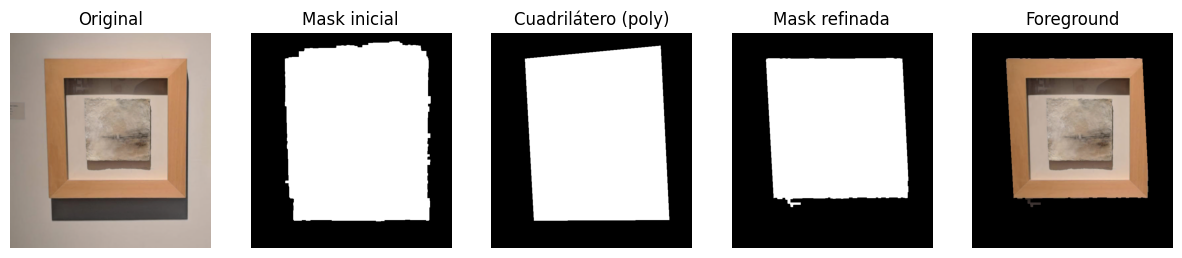

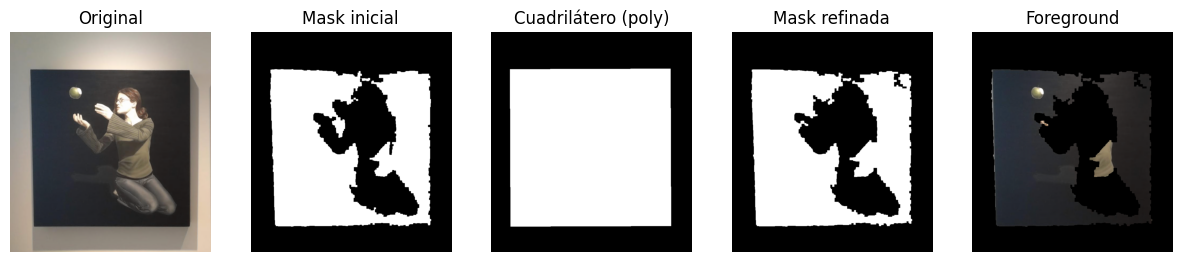

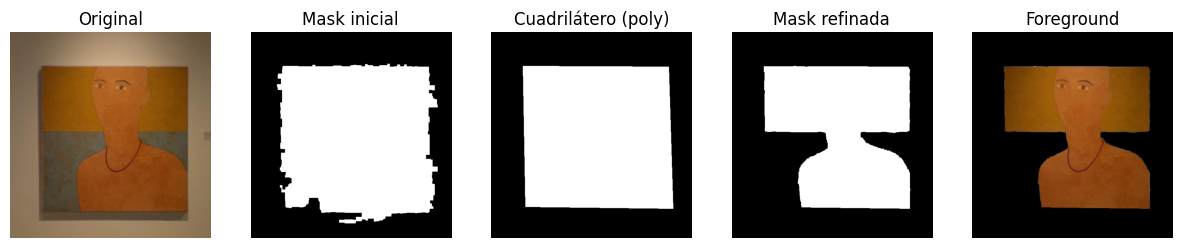

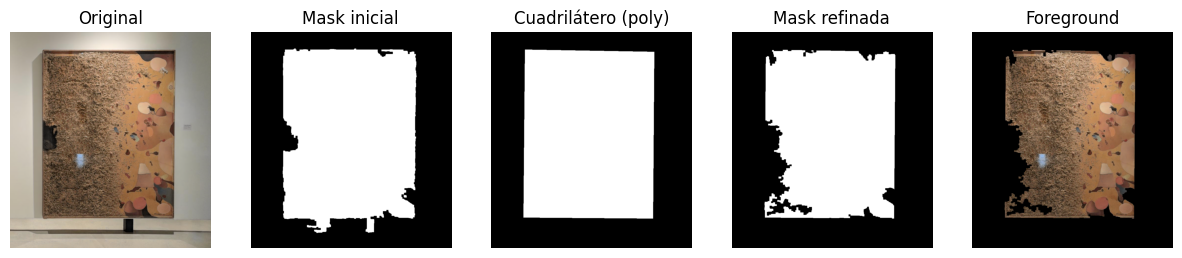

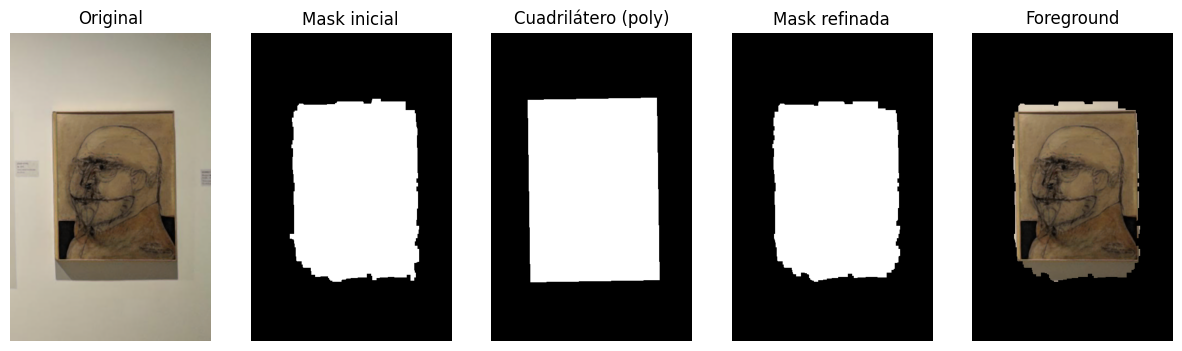

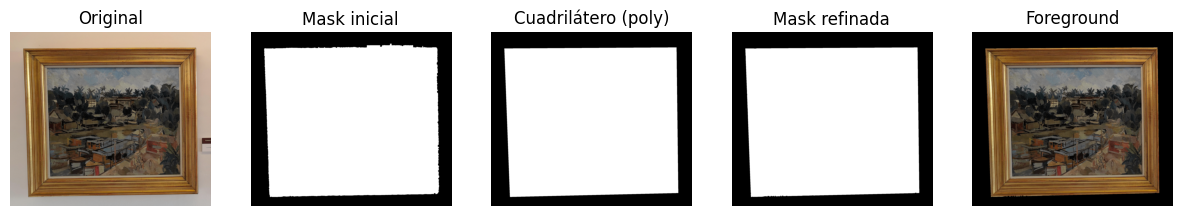

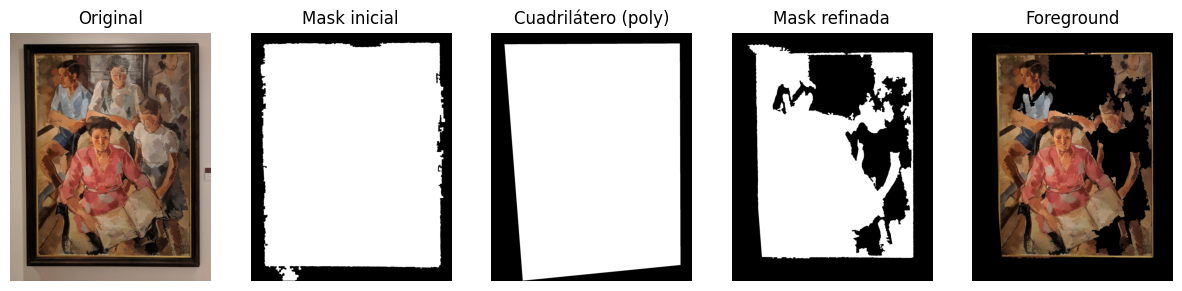

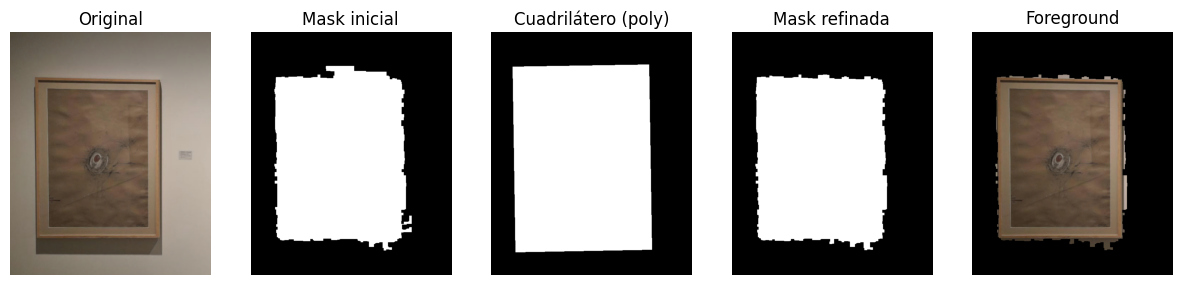

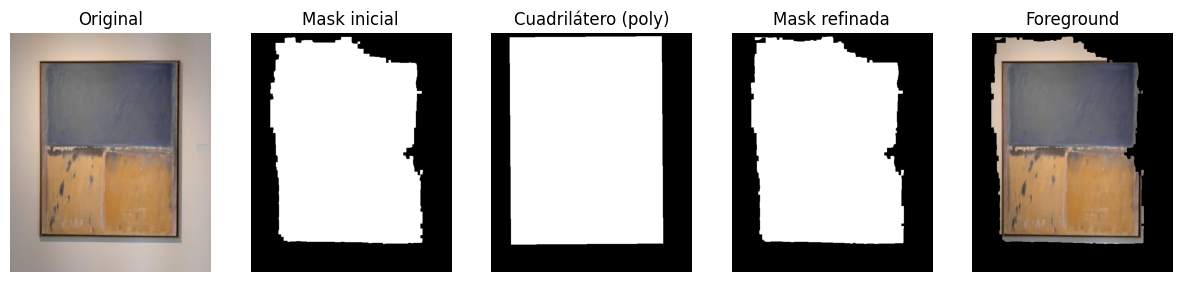

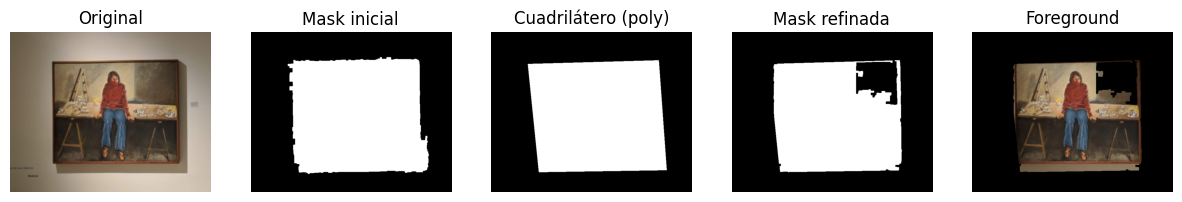

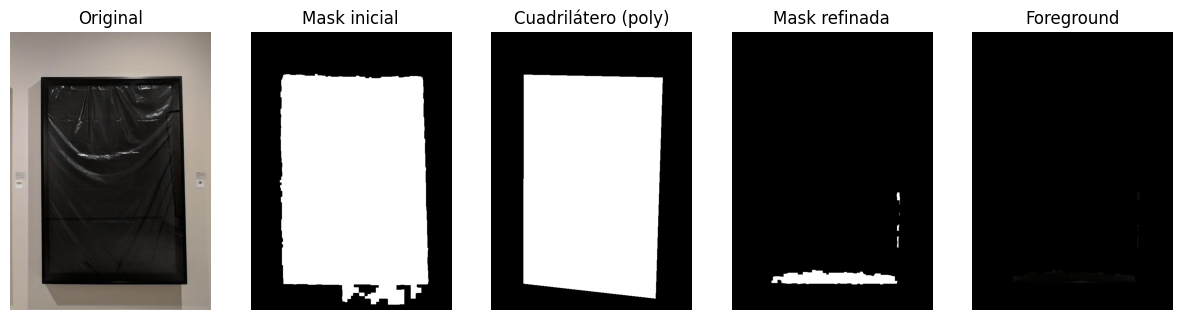

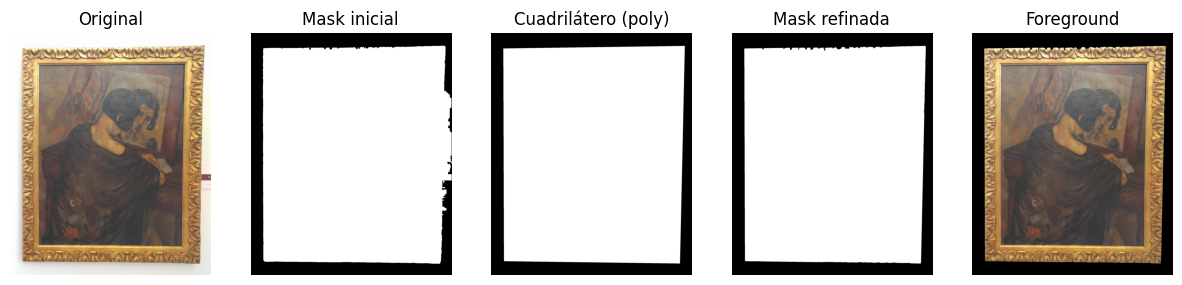

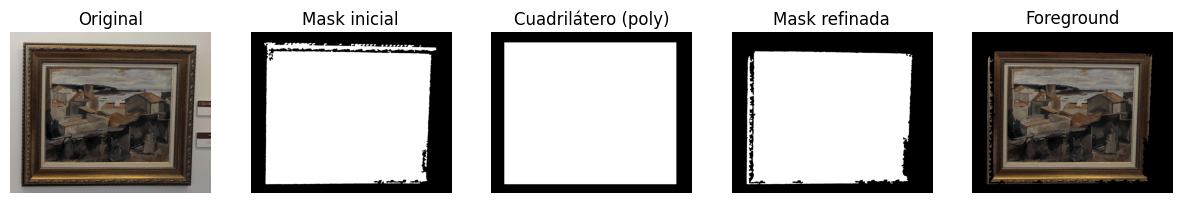

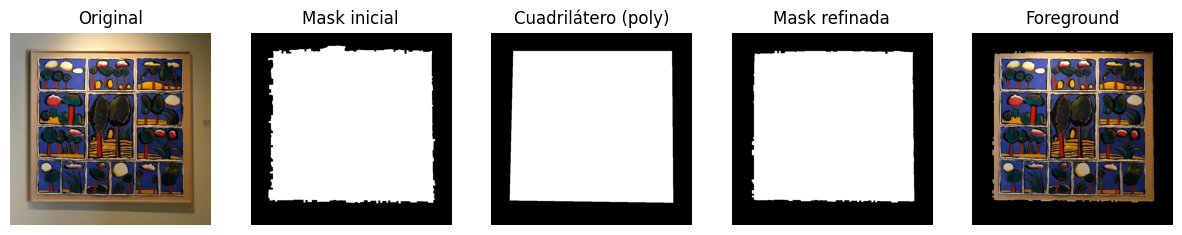

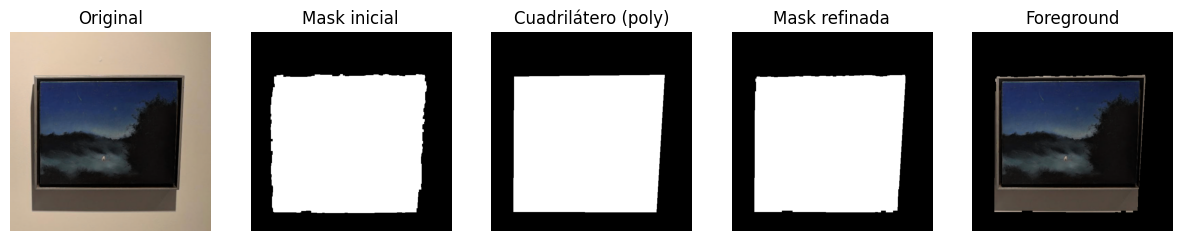

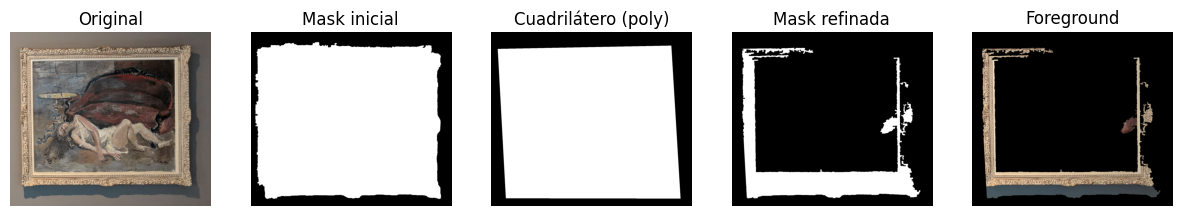

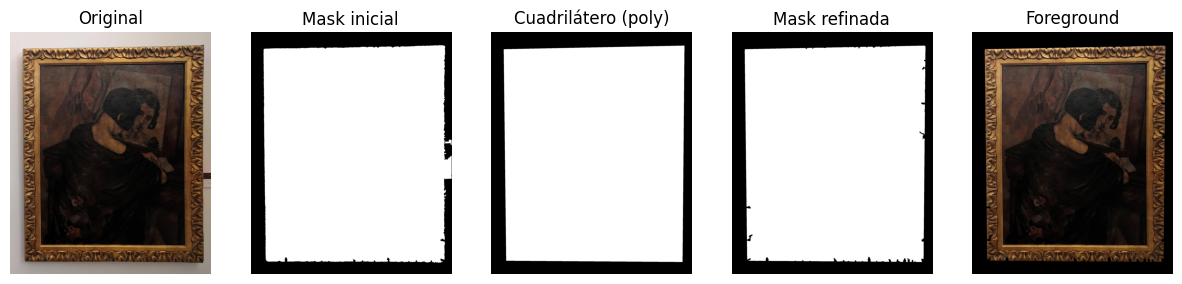

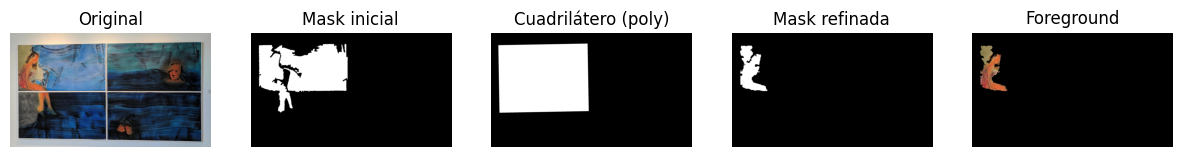

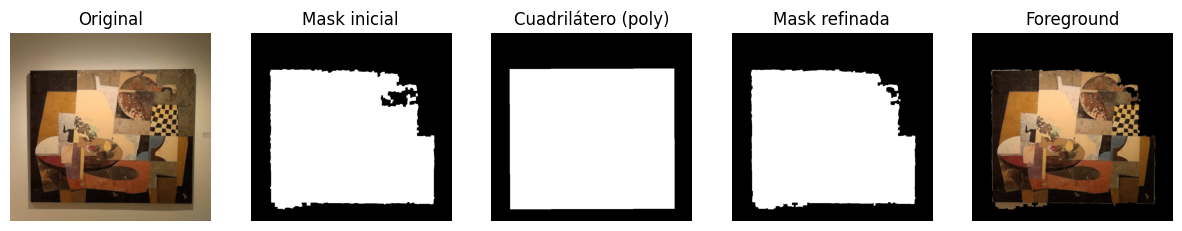

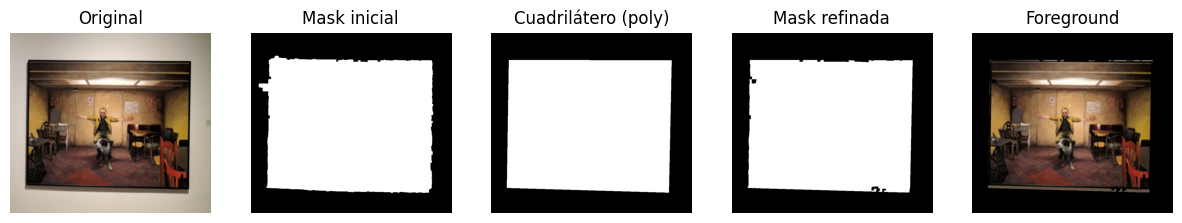

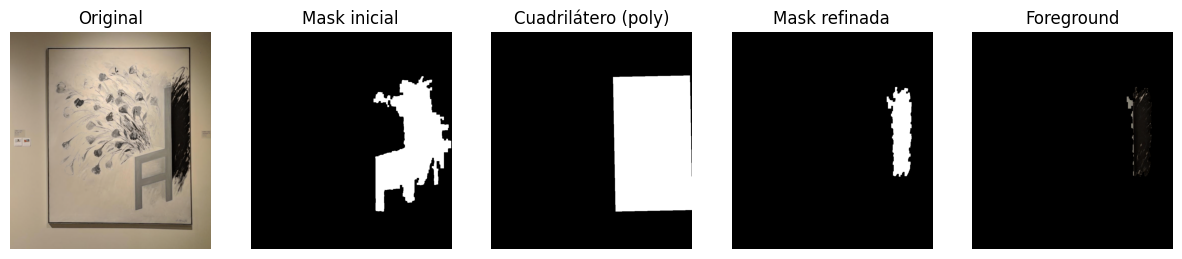

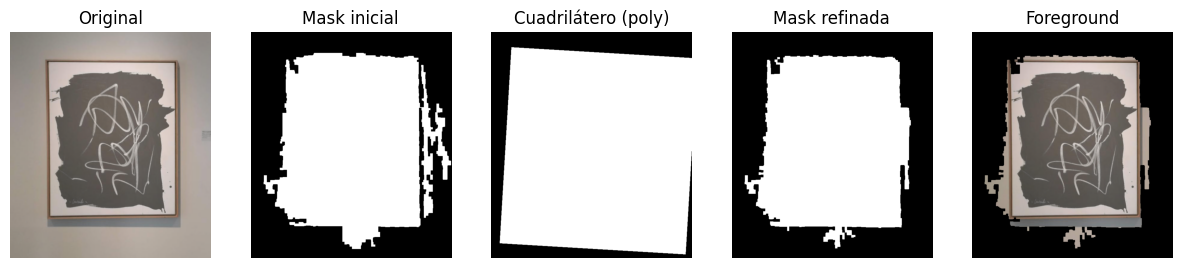

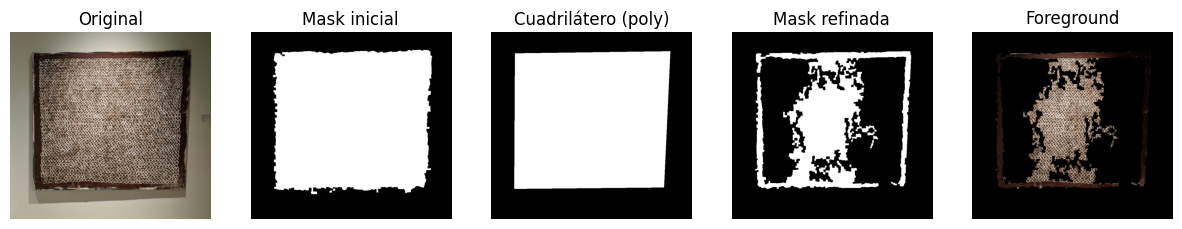

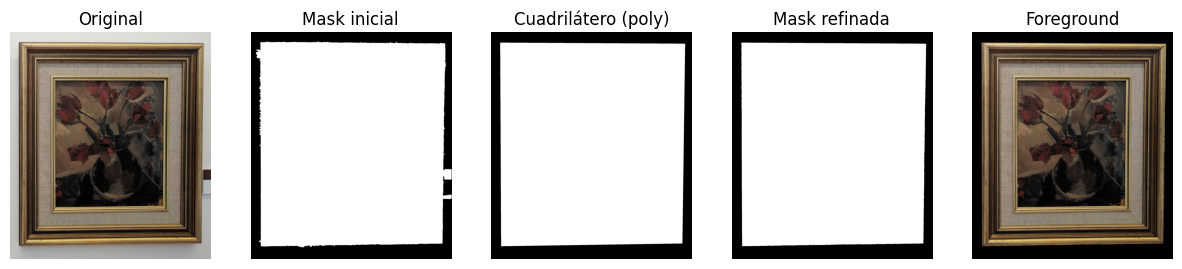

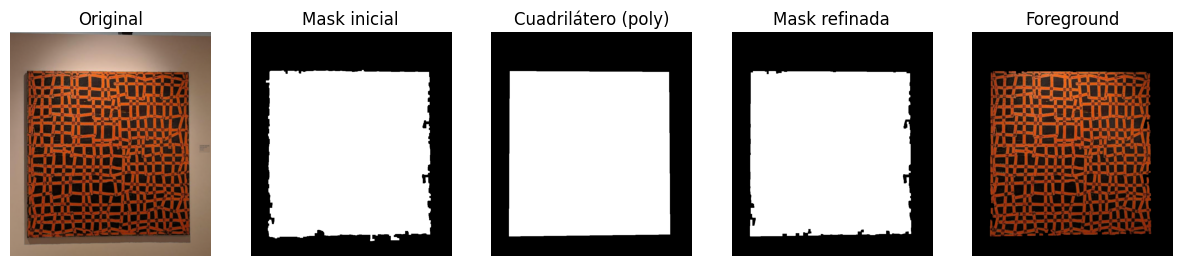

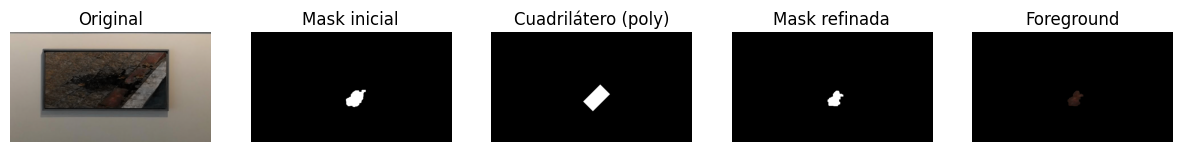

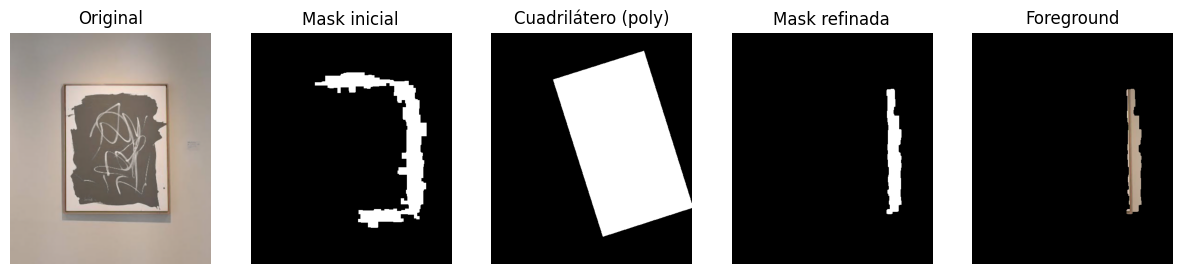

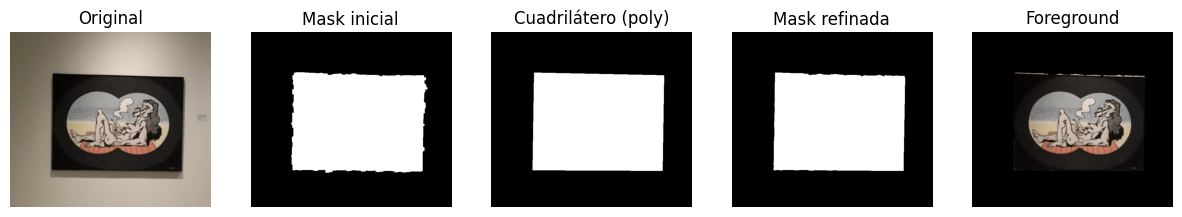

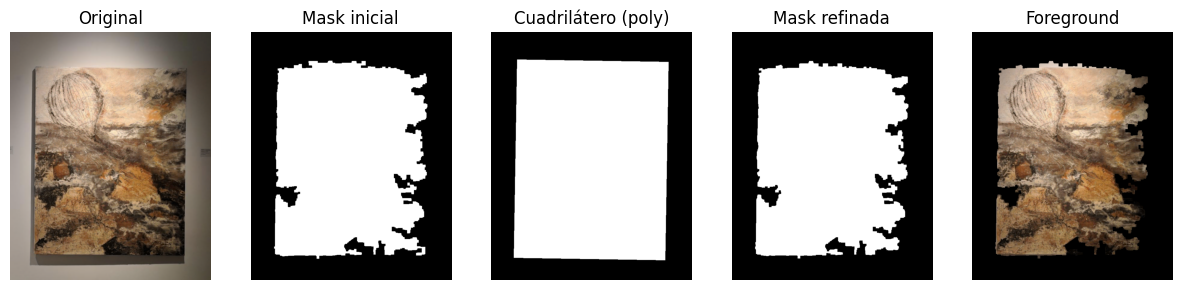

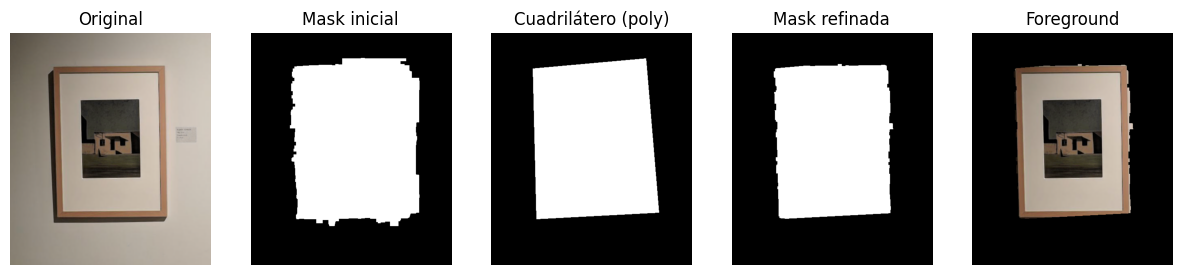

In [23]:
# Process each image
for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    original_image, mask, foreground = remove_background(image_path, border_width=10, open_se=7, close_se=7, tau_percentile=95, filter='median')
    im, mask_init, poly_mask, mask_refined, foreground = refine_with_quadrilateral(original_image, mask, open_se=7, close_se=7, tau_percentile=95)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 5, 1); plt.title('Original'); plt.imshow(im); plt.axis('off')
    plt.subplot(1, 5, 2); plt.title('Mask inicial'); plt.imshow(mask_init, cmap='gray'); plt.axis('off')
    plt.subplot(1, 5, 3); plt.title('Cuadrilátero (poly)'); plt.imshow(poly_mask, cmap='gray'); plt.axis('off')
    plt.subplot(1, 5, 4); plt.title('Mask refinada'); plt.imshow(mask_refined, cmap='gray'); plt.axis('off')
    plt.subplot(1, 5, 5); plt.title('Foreground'); plt.imshow(foreground); plt.axis('off')
    plt.show()